In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import json
from config import remote_db_endpoint, remote_db_port, remote_db_user, remote_db_pwd, remote_db_name

In [3]:
cloud_engine = create_engine(f"postgresql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}/{remote_db_name}")

In [4]:
cloud_conn = cloud_engine.connect()

In [5]:
africa_data = pd.read_sql("select * from ultimate", cloud_conn)

In [6]:
africa_data.columns

Index(['country_name', 'country_code', 'year', 'conflict_code_freq',
       'conflict_deaths_code', 'population_density',
       'population_growth_annual_per', 'total_population',
       'refugee_pop_origin', 'rural_population', 'rural_population_per',
       'rural_population_growth', 'urban_population', 'urban_population_per',
       'urban_population_growth', 'corruption_control_estimate',
       'corruption_control_percentile', 'government _effectiveness_est',
       'government_effectiveness_percentile', 'stability_est',
       'stability_percentile', 'regulatory_est', 'regulatory_percentile',
       'ruleoflaw_est', 'ruleoflaw_percentile', 'accountability_est',
       'accountability_percentile ', 'ethnic_score', 'gdp_growth_per',
       'gdp_percap_per', 'mortality_rate', 'gdp_total', 'gdp_percap',
       'gni_total', 'fdi_inflows_gdp', 'fdi_inflows_total',
       'conflict_fatalities', 'conflict_events'],
      dtype='object')

In [7]:
africa_data=africa_data[['gdp_percap', 'accountability_est', 'government _effectiveness_est', 'ethnic_score', 'gni_total','stability_est', 'mortality_rate', 'ruleoflaw_est', 'corruption_control_estimate', 'conflict_code_freq']]
len(africa_data.columns)

10

In [8]:
X = pd.get_dummies(africa_data.drop(columns='conflict_code_freq'))
y = africa_data['conflict_code_freq']

seed = 1 # used for random_state

In [9]:
# prepare models.. feel free to add others!
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier())) 
models.append(('SVM', SVC()))

models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('NB', GaussianNB()))

models

[('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                       weights='uniform')),
 ('TREE',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best')),

In [10]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.174837 (0.071923)
KNN: 0.270250 (0.052676)
TREE: 0.748332 (0.122134)
RF: 0.879283 (0.131142)
SVM: 0.282168 (0.088046)
LDA: 0.370826 (0.086989)
NB: 0.279408 (0.083943)


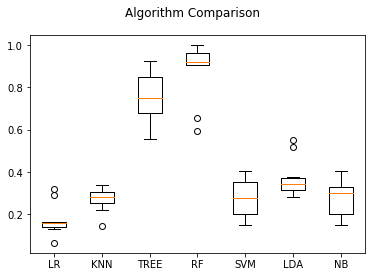

In [11]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()